In [1]:
import os
import os.path as op
import glob
import numpy as np
import pandas as pd
from pandas import DataFrame
import nibabel as nib
import scipy
import matplotlib
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests, _ecdf as ecdf, fdrcorrection as fdrcorrection0, fdrcorrection_twostage
%matplotlib inline

In [1179]:
#preliminary housekeeping
home_dir = '/data/home/iballard/mag/'
subj_file = home_dir + 'subjects.txt'
subs = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)
runs = map(str,range(1,5))

In [1180]:
sns.set_context('paper',font_scale = 2.5)
sns.set(font="Times New Roman")
sns.set_style("white")

In [1207]:
smoothing = 'smoothed'
regspace = 'epi'

exp = 'mag-SVtotaldiff'

rois = ['_amfg',
        '_pmfg',
        '_fpc',
        '_ifg',
        '_psfs',
        '_ifs',
       '_ains',
       '.vmpfc_']

In [1208]:
# subs = [x for x in subs if x!= 'subject09']

In [1209]:
def extract_copes(exp,regspace,smoothing,contrast):
    df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

    for sub in subs:
        cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
            '/' + smoothing + '/' + contrast + '/cope1.nii.gz'
        cope = nib.load(cope).get_data()

        masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
        masks = [m for m in masks if any(substring in m for substring in rois)]

        for m in masks:
            if len(m.split('/')[-1].split('.'))==4:
                hemi = m.split('/')[-1].split('.')[0]
                label = m.split('/')[-1].split('.')[1]
            else:
                hemi = 'na'
                label = m.split('/')[-1].split('.')[0]

            m = nib.load(m).get_data().astype(bool)
            num_voxels = m.sum()
            func_masked = cope[m]
            row = pd.DataFrame([dict(sub = sub, 
                                     contrast =contrast, 
                                     mask_vox = num_voxels, 
                                     hemi = hemi,
                                     label = label, 
                                     value = np.mean(func_masked)), ])
            df = df.append(row, ignore_index = True)
    return df
# extract_copes(exp,regspace,smoothing,contrast)

In [1184]:
# def extract_copes(exp,regspace,smoothing,contrast):
#     df = pd.DataFrame(columns=('sub','contrast','run','HL','mask_vox','hemi','label','value'))

#     for sub in subs:
        
#         sub_dir = op.join(home_dir,'analysis',exp,sub,'reg','epi','smoothed')
#         nruns = len(glob.glob(sub_dir + '/run_*'))
        
#         for run in range(1,nruns+1):
#             cope = op.join(sub_dir, 'run_' + str(run), 
#                            'cope' + contrast2cope[contrast] + '_xfm.nii.gz')

#             cope = nib.load(cope).get_data()

#             masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
#             masks = [m for m in masks if any(substring in m for substring in rois)]
            
#             if run in [1,2] and sub[0] == 'a':
#                 hl = 'high'
#             if run in [1,2] and sub[0] == 's':
#                 hl = 'low'
#             if run in [3,4] and sub[0] == 'a':
#                 hl = 'low'
#             if run in [3,4] and sub[0] == 's':
#                 hl = 'high'                
                
#             for m in masks:
#                 if len(m.split('/')[-1].split('.'))==4:
#                     hemi = m.split('/')[-1].split('.')[0]
#                     label = m.split('/')[-1].split('.')[1]
#                 else:
#                     hemi = 'na'
#                     label = m.split('/')[-1].split('.')[0]

#                 m = nib.load(m).get_data().astype(bool)
#                 num_voxels = m.sum()
#                 func_masked = cope[m]
#                 row = pd.DataFrame([dict(sub = sub, 
#                                          contrast =contrast, 
#                                          mask_vox = num_voxels, 
#                                          hemi = hemi,
#                                          label = label,
#                                          run = run,
#                                          HL = hl,
#                                          value = np.median(func_masked)), ])
#                 df = df.append(row, ignore_index = True)
#     return df

In [1185]:
# def extract_copes(exp,regspace,smoothing,contrast):
#     df = pd.DataFrame(columns=('sub','contrast','mask_vox','hemi','label','value'))

#     for sub in subs:
#         cope = home_dir + '/analysis/' + exp + '/' + sub + '/ffx/' + regspace + \
#             '/' + smoothing + '/' + contrast + '/cope1.nii.gz'
#         cope = nib.load(cope).get_data()

#         masks = glob.glob(home_dir + '/data/' + sub + '/masks/*.*nii.gz')
#         masks = [m for m in masks if any(substring in m for substring in rois)]

#         masks = [m.split('/')[-1].split('.')[1] for m in masks]
#         for m in masks:
#             m1 = op.join(home_dir,'data',sub,'masks','lh.' + m + '.nii.gz')
#             m2 = op.join(home_dir,'data',sub,'masks','rh.' + m + '.nii.gz')
#             m1 = nib.load(m1).get_data().astype(bool)
#             m2 = nib.load(m2).get_data().astype(bool)
#             mask = np.logical_or(m1,m2)
            
#             num_voxels = mask.sum()
#             func_masked = cope[mask]
#             hemi = 'na'
#             row = pd.DataFrame([dict(sub = sub, 
#                                      contrast = contrast, 
#                                      mask_vox = num_voxels, 
#                                      hemi = hemi,
#                                      label = m, 
#                                      value = np.median(func_masked)), ])
#             df = df.append(row, ignore_index = True)
#     return df
# # extract_copes(exp,regspace,smoothing,contrast)

In [1262]:
df = pd.DataFrame({'ROI':['a','b'],
                  'val': [0.0,0.0],
                  'err':[1.0,2.0]})
df['ROI'] = pd.Categorical(df['ROI'], ['b','a'])
df = df.sort('ROI')

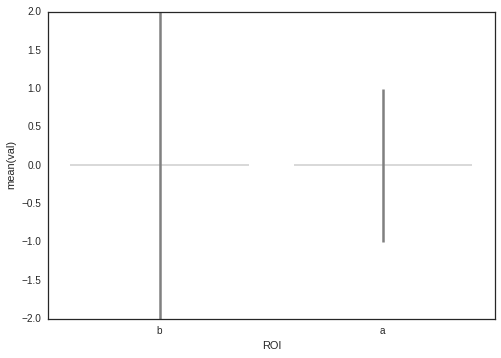

In [1263]:
sns.barplot(x='ROI',y='val',data = df,
#                 x_order = ['b','a'],
            **{'yerr':df['err'],
               'error_kw':dict(ecolor='grey', lw=2.5)})

In [1291]:
def plot_fig(res,contrast):
    plt.figure(figsize=(10, 6))
#     sns.factorplot(x='ROI', y='value', col='contrast', 
#                    aspect=2, kind='bar',ci=68, 
#                    units='sub', data=df,
#                    palette = custom_palette,
#                   x_order = roi_plotting_order)
    #relabel
    res = res.copy()
    res['ROI'] = [label_map[x] for x in res['label'].values]
    
    #sort dataframe
    res['ROI'] = pd.Categorical(res['ROI'],roi_plotting_order)
    res = res.sort('ROI')

    #plot
    sns.barplot(x='ROI',y='val',data = res,
                **{'yerr':res['err'],
                   'error_kw':dict(ecolor='grey', lw=2.5)}
                )
    sns.despine()
    plt.ylabel('Beta (AU)')
    plt.title(title_map[contrast])
    plt.savefig('/home/iballard/Dropbox/mag_figs/' + contrast + '.svg')

In [1187]:
# def run_stats(df):
#     results_df =pd.DataFrame(columns=('contrast','label','nvox','std_vox','p_unc'))
#     for roi in set(df['label']):
        
#         new = df[df['label'] == roi].groupby(['contrast','label','sub']).mean() #average over hemi
#         vals = new.loc[(contrast,roi)]['value'].values
#         vox =  new.loc[(contrast,roi)]['mask_vox'].values


# #         t,p = scipy.stats.wilcoxon(vals)
#         t,p = scipy.stats.ttest_1samp(vals,0)
        
        
#         row = pd.DataFrame([dict(contrast = contrast, 
#                                  label = roi,
#                                  nvox = np.mean(vox),
#                                  std_vox = np.std(vox),
#                                 p_unc = p), ])
#         results_df = results_df.append(row, ignore_index = True)
#     sig,pcorr = fdrcorrection0(results_df['p_unc'],.05)
#     results_df['p_corr'] = pcorr
#     results_df['sig'] = sig
#     return results_df

In [1188]:
label_map = {'yeo17_amfg':'aMFG','yeo17_pmfg':'pMFG','yeo17_ains':'aINS','yeo17_fpc':'FPC',
            'yeo17_ifs':'IFS','yeo17_ifg':'IFG','yeo17_psfs':'FEF','vmpfc_bartre':'vmPFC',
            'vmpfc_bilateral':'vmPFC','mag_figure3D_vmpfc_bartre_mask':'vmPFC'}
roi_plotting_order = ['IFS','FPC','pMFG','FEF','aINS','IFG','aMFG','vmPFC']

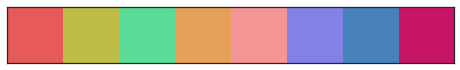

In [1189]:
#get colors from ROI figure and match them
ctab = '/home/iballard/mag/data/fsaverage/label/pfc.ctab'
color = np.loadtxt(ctab,object)
custom_palette = []
for row in color:
    rgb = (int(row[2]),int(row[3]),int(row[4]))
    hex_rgb = '#%02x%02x%02x' % rgb
    roi_id = label_map[row[1]]
    custom_palette.append((hex_rgb, roi_id))

custom_palette.sort(key=lambda x: roi_plotting_order.index(x[1]))
custom_palette = [x[0] for x in custom_palette]

sns.set_palette(custom_palette)
sns.palplot(sns.color_palette())

In [1293]:
def run_contrast(exp,regspace,smoothing,contrast):
    df = extract_copes(exp,regspace,smoothing,contrast)
    df['ROI'] = [label_map[x] for x in df['label'].values]
    
    df.to_csv('/home/iballard/Dropbox/Magnitude_fMRI/roi_analysis/' + exp  + '_' + contrast + '.csv',
              index = False)
    
    results = run_stats(df)
    results['ROI'] = [label_map[x] for x in results['label'].values]

    plot_fig(results,contrast)

    return results

In [1294]:
def run_stats(df):
    results_df =pd.DataFrame(columns=('contrast','label','nvox',
                                      'std_vox','p_unc','val','err'))
    for roi in set(df['label']):

        new = df[df['label'] == roi]

        #run mixed effects model
        model_str = 'value ~ 1'
        mixedfx = smf.mixedlm(model_str, new, groups = new['sub'])    
        mixedfx = mixedfx.fit()
        
        #extract p value and errors
        p = mixedfx.pvalues['Intercept']
        val = mixedfx.params[0]
#         err = mixedfx.bse_fe[0] #standard error
        conf_int = mixedfx.conf_int()
        err = (conf_int.loc['Intercept',1] - conf_int.loc['Intercept',0]) / 2.0 #plots 95% conf
        
        #update dataframe
        row = pd.DataFrame([dict(contrast = contrast, 
                                 label = roi,
                                 nvox = np.mean(new['mask_vox']),
                                 val = val,
                                 err = err,
                                p_unc = p), ])
        results_df = results_df.append(row, ignore_index = True)
    sig,pcorr,a1,a2 = multipletests(results_df['p_unc'],.05,method = 'fdr_tsbh')
    results_df['p_corr'] = pcorr
    results_df['sig'] = sig
    return results_df


In [1205]:
print scipy.stats.ttest_1samp(ifs['value'],0)
print scipy.stats.wilcoxon(ifs.groupby(['sub']).mean()['value'])
print scipy.stats.ttest_1samp(ifs.groupby(['sub']).mean()['value'],0)


Ttest_1sampResult(statistic=3.0386134452250935, pvalue=0.0043435977814088086)
WilcoxonResult(statistic=35.0, pvalue=0.015755486091547432)
Ttest_1sampResult(statistic=2.4536716035119608, pvalue=0.024556449400465207)


In [1296]:
df = extract_copes(exp,regspace,smoothing,'decision')
df['ROI'] = [label_map[x] for x in df['label'].values]
results = run_stats(df)
results['ROI'] = [label_map[x] for x in results['label'].values]
# plot_fig(results,contrast)
df = df.set_index(['ROI'])

yeo17_ifg high_minus_low
yeo17_fpc high_minus_low
yeo17_amfg high_minus_low
yeo17_ains high_minus_low


/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


yeo17_ifs high_minus_low
yeo17_pmfg high_minus_low
vmpfc_bartre high_minus_low
yeo17_psfs high_minus_low


In [1243]:
ifs = df.loc[('IFS')]
model_str = 'value ~ 1'
mixedfx = smf.mixedlm(model_str, ifs, groups = ifs['sub'])    
mixedfx = mixedfx.fit()
print mixedfx.summary()
# mixedfx.pvalues['Intercept']

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 38      Method:             REML    
No. Groups:       19      Scale:              2.7714  
Min. group size:  2       Likelihood:         -81.9103
Max. group size:  2       Converged:          Yes     
Mean group size:  2.0                                 
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     1.132    0.439 2.580 0.010  0.272  1.991
Intercept RE  2.271    1.082                          



In [178]:
df.to_csv('/home/iballard/Dropbox/mag_figs/roi_results.csv',index = False)

In [245]:
contrasts = ['decision',
             'SV_total',
             'neg_SV_diff',
             'low_minus_high_SV_diff',
             'high_minus_low_SV',
            'high_minus_low']
contrast2cope = {'decision':'1',
                 'SV_total':'20',
                 'neg_SV_diff':'11',
                 'low_minus_high_SV_diff':'13',
                 'high_minus_low_SV':'21',
                 'high_minus_low':'14'}

title_map = {'rt':'rt',
             'high_minus_low_dm': 'high_minus_low_decision',
             'diff':'Difficulty',
             'high_minus_low_diff':'Difficulty (High minus Low Magnitude)',
             'decision_motor': 'decision_motor',
             'decision': 'Decision Period',
             'SV_total': 'Subjective Value',
             'neg_SV_diff': 'Difficulty',
             'SV_max': 'Subjective Value',
             'low_minus_high_SV_diff': 'Difficulty (High minus Low Magnitude)',
             'high_minus_low_SV': 'Subjective Value (High minus Low Magnitude)',
            'high_minus_low': 'High minus Low Magnitude'}


In [1290]:
# pd.concat([all_results[0][['ROI','p_unc','p_corr','sig']],all_results[1][['ROI','p_unc','p_corr','sig']]])

In [1295]:
all_results = []

for contrast in contrasts:
    results = run_contrast(exp,regspace,smoothing,contrast)
    all_results.append(results.copy())
    
all_results = pd.concat(all_results)
all_results = all_results.set_index(['contrast'])

yeo17_ifg decision
yeo17_fpc decision
yeo17_amfg decision
yeo17_ains decision


/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home/iballard/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


yeo17_ifs decision
yeo17_pmfg decision
vmpfc_bartre decision
yeo17_psfs decision
yeo17_ifg SV_total
yeo17_fpc SV_total
yeo17_amfg SV_total
yeo17_ains SV_total
yeo17_ifs SV_total
yeo17_pmfg SV_total
vmpfc_bartre SV_total
yeo17_psfs SV_total
yeo17_ifg neg_SV_diff
yeo17_fpc neg_SV_diff
yeo17_amfg neg_SV_diff
yeo17_ains neg_SV_diff
yeo17_ifs neg_SV_diff
yeo17_pmfg neg_SV_diff
vmpfc_bartre neg_SV_diff
yeo17_psfs neg_SV_diff
yeo17_ifg low_minus_high_SV_diff
yeo17_fpc low_minus_high_SV_diff
yeo17_amfg low_minus_high_SV_diff
yeo17_ains low_minus_high_SV_diff
yeo17_ifs low_minus_high_SV_diff
yeo17_pmfg low_minus_high_SV_diff
vmpfc_bartre low_minus_high_SV_diff
yeo17_psfs low_minus_high_SV_diff
yeo17_ifg high_minus_low_SV
yeo17_fpc high_minus_low_SV
yeo17_amfg high_minus_low_SV
yeo17_ains high_minus_low_SV
yeo17_ifs high_minus_low_SV
yeo17_pmfg high_minus_low_SV
vmpfc_bartre high_minus_low_SV
yeo17_psfs high_minus_low_SV
yeo17_ifg high_minus_low
yeo17_fpc high_minus_low
yeo17_amfg high_minus_low

In [1213]:
all_results[['ROI','p_unc','p_corr','sig']]

,ROI,p_unc,p_corr,sig
contrast,,,,
decision,IFG,6.289789e-07,4.717342e-07,True
decision,FPC,1.322992e-02,7.937951e-03,True
decision,aMFG,5.383516e-02,2.691758e-02,True
decision,aINS,3.119109e-09,4.678664e-09,True
decision,IFS,6.722772e-08,6.722772e-08,True
decision,pMFG,3.775405e-01,1.415777e-01,False
decision,vmPFC,2.181896e-38,6.545687e-38,True
decision,FEF,3.078905e-01,1.319531e-01,False
SV_total,IFG,5.069563e-01,6.159608e-01,False


In [1214]:
# for s in subs:
#     sub_path = op.join(home_dir,'analysis','mag',s,'preproc')
#     for run_path in glob.glob(sub_path + '/*'):
#         out = op.join(run_path,'nuisance_variables.csv')
#         out_art =  op.join(run_path,'artifacts.csv')
        
#         artifacts =  op.join(run_path,'artifacts_real.csv')
#         artifacts = pd.read_csv(artifacts)
        
#         nuisance = op.join(run_path,'nuisance_variables_brain.csv')
#         nuisance = pd.read_csv(nuisance)
#         nuisance['brain'] = 0
#         if run_path == '/data/home/iballard/mag/analysis/mag/subject08/preproc/run_3':
#             idx = 0
#         else:
#             idx = artifacts[artifacts['intensity'] == 1].index[0]
#             artifacts.loc[idx,'intensity'] = 0
#         nuisance.loc[idx,'brain'] = 1

#         nuisance.to_csv(out,index = False)
#         artifacts.to_csv(out_art, index = False)

In [1144]:
for s in subs:
    sub_path = op.join(home_dir,'analysis','mag',s,'preproc')
    for run_path in glob.glob(sub_path + '/*'):
        in_f = op.join(run_path,'nuisance_variables.csv')
        out_f = op.join(run_path,'nuisance_variables_artefact_no_brain.csv')
        cmd = ['mv',in_f,out_f]
        os.system(' '.join(cmd))

        real_art = op.join(run_path,'nuisance_variables_brain.csv')
        cmd = ['mv',real_art,in_f]
        os.system(' '.join(cmd))
       

['asu4', 'asu8', 'asu10', 'asu11', 'asu12', 'asu13', 'subject03', 'subject04', 'subject05', 'subject06', 'subject08', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject20', 'subject21']


In [960]:
params = pd.read_csv('/home/iballard/Dropbox/Magnitude_fMRI/model_fits.csv')
params['mag_effect'] = np.array(map(np.log,params['k_low'])) - np.array(map(np.log,params['k_high']))
bad_subs = ['asu03','asu09','subject22']
for s in bad_subs:
    params = params[params['sub'] != s]
params = params.reset_index()

In [961]:
for n,s in enumerate(params['sub']):
    if s == 'asu04':
        params['sub'][n] = 'asu4'
    if s == 'asu08':
        params['sub'][n] = 'asu8'

/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/iballard/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


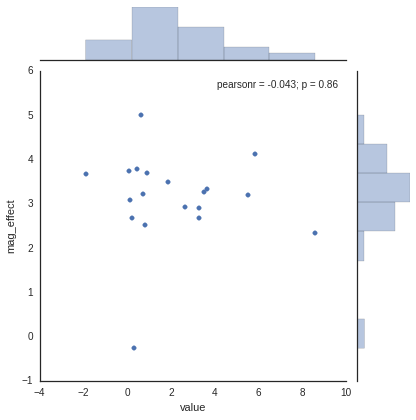

In [972]:
ifs2 = ifs.groupby('sub').mean().reset_index()
ifs2 = pd.merge(ifs2,
         params,
        how = 'left',
        on = 'sub')
sns.jointplot(x = 'value',y= 'mag_effect', data = ifs2)

In [946]:
# ifs2.columns = ifs2.columns.get_level_values(0)
# ifs2['mag_effect'] = params['mag_effect']

In [947]:
ifs2

,sub,mask_vox,value,mag_effect
0,asu10,920.0,1.452723,NaN
1,asu11,626.0,-0.549734,NaN
2,asu12,782.0,3.039284,NaN
3,asu13,1038.0,0.858649,NaN
4,asu4,776.5,-2.351623,NaN
5,asu8,757.0,1.667026,NaN
6,subject03,358.5,3.035406,NaN
7,subject04,316.5,-1.428086,NaN
8,subject05,351.5,3.792463,NaN
9,subject06,423.5,1.710646,NaN
